In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats

from copy import deepcopy

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🦠 Breast Cancer 🩺 EDA and Classification 🧬

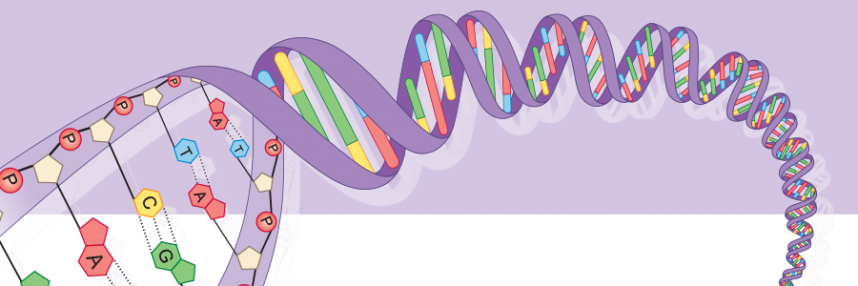

In [ ]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
df.head()

Firstly, we can check that id and Unamed: 32 are useless features so we can drop them.

Then we can check dtypes

In [ ]:
y = df['diagnosis']
df = df.drop(['id', 'Unnamed: 32', 'diagnosis'], axis=1)

features_mean= list(df.columns[:10])
features_se= list(df.columns[10:19])
features_worst=list(df.columns[20:])

In [ ]:
df.describe()

As we can see, all the variables are numerical.

* In this kind of problemas we have to be aware the numiercal datya distributions, skew, outliers, and so on. 
* We won't need to feature encoding 
* I have the intuition that some variables are going to be correlated so i will have to do a feature selection

So, lets go for it!

In [ ]:
# I want to thanks @masumrumi for sharing this amazing plot!
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

# 1. Data Visualization 📊

## Target

Lets see the target distribution

In [ ]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
b, m = y.value_counts()
print(b, m)

As we can see, the classes are not equaly balanced so we have to take it into consideration in the future.

The imbalanced ratio is not so hard, so for now we will let the variable as it is.

## Independent variables: study the distribution

In [ ]:
# Explore Fare distribution 
g = sns.distplot(df["radius_mean"], color="m", label="Skewness : %.2f"%(df["radius_mean"].skew()))
g = g.legend(loc="best")

In [ ]:
num_rows, num_cols = 5,2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 12))
fig.tight_layout()

for index, column in enumerate(df[features_mean].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.distplot(df[column], color="m", label="%.2f"%(df[column].skew()), ax=axes[i,j])
    g = g.legend(loc="best")

As we can see, some of the variables are little skewed. As all the values are below 1.5, we can ommit it.

The other clear conclusion is that the data is not scaled and standarized. We could try to this options.

## Independent variables: kernel density estimation

In [ ]:
# Explore Age distibution 
g = sns.kdeplot(df["radius_mean"][(y == 'B') & (df["radius_mean"].notnull())], color="Red", shade=True)
g = sns.kdeplot(df["radius_mean"][(y == 'M') & (df["radius_mean"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("radius_mean")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [ ]:
df_b = df[y == 'B']
df_m = df[y == 'M']

num_rows, num_cols = 5,2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 12))
fig.tight_layout()

for index, column in enumerate(df[features_mean].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.kdeplot(df_b[column], color="Red", shade=True, ax=axes[i,j])
    g = sns.kdeplot(df_m[column], ax=g, color="Blue", shade=True)
    g.set_xlabel(column)
    g = g.legend(["Benign","Malignant"])

As we can see, many of the variables have distinct distributions from Benign to Malignant so we could think that these are going to be relevant variables.

On the other hand, those variables with almost the same distribution in Benign and Malignant probably wont be as much important as others are.

## Correlation

In [ ]:
sns.set(rc={'figure.figsize':(16,12)})

In [ ]:
corr = df[features_mean].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Selecting upper triangle of correlation matrix
upper_tri = corr.where(np.triu(np.ones(corr.shape),
                                  k=1).astype(np.bool))

# Finding index of feature columns with correlation greater than 0.95
mean_set_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print('Features to drop: {}'.format(mean_set_to_drop))

As we can see, there are some correlated variables. So we need to drop some of them. In this case, we decided to drop: ['perimeter_mean', 'area_mean']

In [ ]:
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# plot heatmap
sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap='coolwarm',
           cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Selecting upper triangle of correlation matrix
upper_tri = corr.where(np.triu(np.ones(corr.shape),
                                  k=1).astype(np.bool))

# Finding index of feature columns with correlation greater than 0.95
full_set_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print('Features to drop: {}'.format(full_set_to_drop))

Now we are comparing all the variables in the dataset so there are a higher number of features correlated.

As we can see, there are some correlated variables. So we need to drop some of them. In this case, we decided to drop: ['perimeter_mean', 'area_mean', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst']

## First try model

At this point, I think that we have so many things to do, but i want to see how the model works with all the features and only the `mean`ones.

So, the first thing we are going to do is to train a naive model (Random Forest) with both sets and save the accuracy.

In the next steps, we will compare these accuracy to see which is the impact in the model performance.

### Full set

In [ ]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print("Accuracy: %.4f%%" % (ac * 100.0))

As we can see, its a really high performace without doing anything at the dataset, so it seems to be a easy problem.

In the next steps we will try to get a higher performance and reduce the dimensionality.

## Mean subset

In [ ]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(df[features_mean], y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print("Accuracy: %.4f%%" % (ac * 100.0))

In this case, it seems that we are losing information. Anycase, it's still a good result.

# 2. Feature engineering 🛠

## Encode label

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

## Fix Skewness

The first thing we are going to try (to see how it impacts the modle performance) is to reduce the distributions skewness with boxcox transformation.

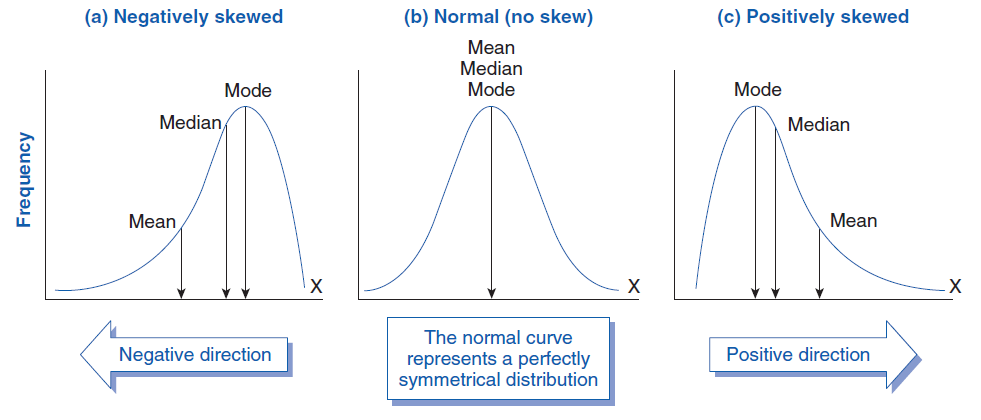

In [ ]:
def fix_skew(features):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numerical_columns = features.select_dtypes(include=['int64','float64']).columns

    # Check the skew of all numerical features
    skewed_features = features[numerical_columns].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
    high_skew = skewed_features[abs(skewed_features) > 0.5]
    skewed_features = high_skew.index

    # Perform the Box-Cox transformation
    for column in skewed_features:
        features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))
        
    return features

In [ ]:
plotting_3_chart(df, 'concavity_mean')

In [ ]:
df_skew = fix_skew(df)

In [ ]:
plotting_3_chart(df, 'concavity_mean')

As we can see in this plot, the distribution skewness has changhed, but the Probability Plots are very similar.

In [ ]:
num_rows, num_cols = 5,2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 12))
fig.tight_layout()

for index, column in enumerate(df[features_mean].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.distplot(df_skew[column], color="m", label="%.2f"%(df_skew[column].skew()), ax=axes[i,j])
    g = g.legend(loc="best")

As we can see, the [BoxCox function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) have completlely fixed the skewness of the variables.

So now, we have to check if this transformacion have had any impact in the model performace.

## Second try model

In [ ]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(df_skew, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print("Accuracy: %.4f%%" % (ac * 100.0))

As we can see, this transformation hasn't have any impact in the model poerformance, so we can discard it.

# 3. Feature selection 🔭

## PCA: Principal Component Analysis

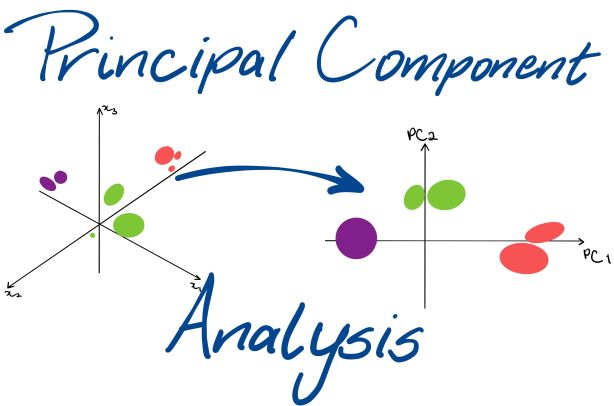

The first thing we are going to do is to Standarize the data so we can 

In [ ]:
from sklearn.preprocessing import StandardScaler
sscal = StandardScaler()
sscal.fit(df)
df_scaled = sscal.transform(df)

Now that the data is scaled, we can use PCA.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_scaled)

plt.figure(1, figsize=(8, 7))
plt.clf()
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

As we can see, it seems that we can explain all the data with **3 or more features**.

In [ ]:
pca = PCA(n_components=3)
pca.fit(df)

df_pca = pca.transform(df)

As we can see, with only 3 features, we can explain almost the 100% of the information in the original plot!!

### Third try model

In [ ]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print("Accuracy: %.4f%%" % (ac * 100.0))

# 4. Modeling 📚🔮

Now with the final subset of variables, we are going to select and tune the final model.

## Test XGBoost model

In [ ]:
from datetime import datetime

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [ ]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.3, random_state=42)

model = XGBClassifier()
model.fit(x_train, y_train)

In [ ]:
# make predictions for test data
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.4f%%" % (accuracy * 100.0))

## Hyperparameter tunning

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 10, 40],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10]
        }

xgb = XGBClassifier(
    learning_rate=0.02, 
    n_estimators=600,
    silent=True, 
    nthread=1
)

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=42)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(df_pca, y), 
    verbose=3, 
    random_state=42
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(df_pca, y)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
best_params = random_search.best_params_
best_params

As we can see, we have earned a very good result. So now we can train the final model.

## Final model

In [ ]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.3, random_state=42)

model = XGBClassifier(
    subsample=0.6,
    min_child_weigth=1,
    max_depth=5,
    gamma=1.5,
    colsample_bytree=0.8,
)
model.fit(x_train, y_train)

In [ ]:
# make predictions for test data
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.4f%%" % (accuracy * 100.0))